In [1]:
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing,feature_selection
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers

In [2]:
review=pd.read_csv('Review_project_sentiment_wUser.csv')

In [3]:
review.head(2)

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date,...,language,text_clean,read_ease,polarity,subjectivity,Adj_ratio,review_count,NumElite,average_stars,NumofWords
0,1073206,JdReKgETiiJEDmshrO4TLw,pyarmAnR-i-qookQamqRTA,V2GOReqPvr8qpCC7sWfoTw,1.0,17,1,0,Just to let this car company that people DO re...,2014-03-06 12:38:52,...,en,let car company people read yelp check review ...,85.49,-0.500000,1.000000,0.120000,9,0,3.00,56
1,6229216,zL4se_Ixdcl8kvTOHCS3rg,s16-BUo-orUsELvMu5ocKg,VH0Ib9S3E-dxbQdQC4rffg,1.0,15,6,4,Mistral was the worst dining experience I have...,2010-07-22 18:08:01,...,en,mistral worst dining experience ever life bad ...,79.19,0.029864,0.502499,0.225888,1777,10,3.82,767


In [4]:
dtf_train, dtf_test = model_selection.train_test_split(review, test_size=0.1)
## get target
y_train = dtf_train["useful_level"].values
y_test = dtf_test["useful_level"].values

In [5]:
corpus1 = dtf_train["text_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus1:
    lst_words = string.split() 
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)

In [6]:
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, vector_size=300,  window=8, min_count=1, sg=1)# sg=1 skip gram/sg=0 SBOW

In [7]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_trainw2v = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=200, padding="post", truncating="post")

In [8]:
i = 1

## list of text: ["I like this", ...]
len_txt = len(dtf_train["text_clean"].iloc[i].split())
print("from: ", dtf_train["text_clean"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_trainw2v[i])
print("to: ", X_trainw2v[i], "| len:", len(X_trainw2v[i]))

## vocabulary: 
print("check: ", dtf_train["text_clean"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[dtf_train["text_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  roommate good experience working al davis eplace apartment hunting particularly appreciated eplace working al al followed u first place showed u wasnt good fit u though looked quite promising description eplaces database continued suggest place u fit criterion came market many realtor dropped u radar first meeting didnt result u renting find apartment would contact ifwhen move | len: 57
to:  [ 2780     7    35   301  2267  6337 18076   438  7020  1554  1403 18076
   301  2267  2267  1561    19    29     4   620    19   117     7   854
    19   129   249   256  4892  2237 45083  9856  1491  1165     4    19
   854  6048    42   608    87  3575  1238    19  5473    29  1170    24
   729    19  3043    85   438     9   752 17058   386     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0  

In [9]:
corpus2 = dtf_test["text_clean"]

## create list of n-grams
lst_corpus2 = []
for string in corpus2:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus2.append(lst_grams)

In [10]:
lst_text2seq2 = tokenizer.texts_to_sequences(lst_corpus2)

## padding sequence
X_testw2v = kprocessing.sequence.pad_sequences(lst_text2seq2, maxlen=200,
             padding="post", truncating="post")

In [11]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [12]:
X_trainw2v.shape

(49668, 200)

In [13]:
X_testw2v.shape

(5519, 200)

In [14]:
y_test = dtf_test["useful_level"]
y_train= dtf_train["useful_level"]
y_train

35826    0
53717    0
30364    0
24437    0
53183    2
        ..
31223    0
7254     0
12511    1
25668    0
40720    2
Name: useful_level, Length: 49668, dtype: int64

In [15]:
EmbeddingTrain = pd.DataFrame(X_trainw2v) #Train set of word2vec features only
EmbeddingTest = pd.DataFrame(X_testw2v)   #Test set of word2vec features only
EmbeddingTrain

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,51,8,17,810,1020,169,280,113,191,307,...,0,0,0,0,0,0,0,0,0,0
1,2780,7,35,301,2267,6337,18076,438,7020,1554,...,0,0,0,0,0,0,0,0,0,0
2,10,3262,460,1555,4426,54,1473,269,1229,3262,...,0,0,0,0,0,0,0,0,0,0
3,29,2,2014,43,156,3702,1079,656,386,7382,...,0,0,0,0,0,0,0,0,0,0
4,162,2966,1277,1960,206,9,55,162,7,151,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49663,45082,12087,54,820,54,12,97,39,22840,2099,...,0,0,0,0,0,0,0,0,0,0
49664,99,404,79,75,39,10,401,301,36,1260,...,0,0,0,0,0,0,0,0,0,0
49665,42,704,4374,7510,600,10,4,19602,4045,125,...,0,0,0,0,0,0,0,0,0,0
49666,3185,44461,4,156,46,725,825,8,134,125,...,0,0,0,0,0,0,0,0,0,0


In [16]:
AllotherTrain = dtf_train[["useful_level", "read_ease", "polarity", "subjectivity", "Adj_ratio", 'review_count', 'NumElite', 'NumofWords']]
AllotherTest = dtf_test[["useful_level", "read_ease", "polarity", "subjectivity", "Adj_ratio", 'review_count', 'NumElite', 'NumofWords']]

In [17]:
Xt1 = AllotherTrain.loc[:, AllotherTrain.columns != 'useful_level']     #Train set of all other features
yt1 = AllotherTrain.loc[:, AllotherTrain.columns == 'useful_level'].values  #Train y
Xv1 = AllotherTest.loc[:, AllotherTest.columns != 'useful_level']       #Test set of all other features
yv1 = AllotherTest.loc[:, AllotherTest.columns == 'useful_level'].values    #Test y

In [18]:
yt1.shape

(49668, 1)

## Other features + Word2Vec Blending classifier

In [19]:
NTrain_w2v, Val_w2v,NTrain_other,Val_other,NTrain_y,Val_y = model_selection.train_test_split(EmbeddingTrain, Xt1 ,pd.DataFrame(y_train), test_size=0.2,stratify=y_train)

In [20]:
y_train

35826    0
53717    0
30364    0
24437    0
53183    2
        ..
31223    0
7254     0
12511    1
25668    0
40720    2
Name: useful_level, Length: 49668, dtype: int64

In [21]:
from time import time
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [22]:
Test_other=Xv1
t0 = time()

# initializing all the base model objects with default parameters
model_1 = LogisticRegression()
model_2 = xgb.XGBRegressor()
model_3 = GaussianNB()
model_4 = RandomForestClassifier()
model_5 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
# model_3 = RandomForestRegressor()

# training all the model on the train dataset

# tfidf
model_4.fit(NTrain_w2v, NTrain_y)
val_pred_1 = model_4.predict(Val_w2v)
test_pred_1 = model_4.predict(X_testw2v)

# converting to dataframe
val_pred_1 = pd.DataFrame(val_pred_1)
test_pred_1 = pd.DataFrame(test_pred_1)

# other
model_2.fit(NTrain_other, NTrain_y)
val_pred_2 = model_2.predict(Val_other)
test_pred_2 = model_2.predict(Test_other)

# converting to dataframe
val_pred_2 = pd.DataFrame(val_pred_2)
test_pred_2 = pd.DataFrame(test_pred_2)

# # training third model
# model_3.fit(x_train, y_train)
# val_pred_3 = model_1.predict(x_val)
# test_pred_3 = model_1.predict(x_test)

# # converting to dataframe
# val_pred_3 = pd.DataFrame(val_pred_3)
# test_pred_3 = pd.DataFrame(test_pred_3)

# concatenating validation dataset along with all the predicted validation data (meta features)

print(time() - t0)

<ipython-input-22-985cdcd40984>:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_4.fit(NTrain_w2v, NTrain_y)


21.50093102455139


In [23]:
X_testw2v = pd.DataFrame(X_testw2v)
Val_w2v['new_col'] = range(1, len(Val_w2v) + 1)
Val_other['new_col'] = range(1, len(Val_other) + 1)
val_pred_1['new_col'] = range(1, len(val_pred_1) + 1)
val_pred_2['new_col'] = range(1, len(val_pred_2) + 1)
X_testw2v['new_col'] = range(1, len(X_testw2v) + 1)
Test_other['new_col'] = range(1, len(Test_other) + 1)
test_pred_1['new_col'] = range(1, len(test_pred_1) + 1)
test_pred_2['new_col'] = range(1, len(test_pred_2) + 1)

<ipython-input-23-f96f484264c3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Val_w2v['new_col'] = range(1, len(Val_w2v) + 1)
<ipython-input-23-f96f484264c3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Val_other['new_col'] = range(1, len(Val_other) + 1)


In [24]:
(X_testw2v)

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,new_col
0,2704,11,373,2704,201,329,198,4,906,188,...,0,0,0,0,0,0,0,0,0,1
1,234,21,719,292,53,11567,105,811,194,105,...,0,0,0,0,0,0,0,0,0,2
2,10,73,7,396,851,174,354,1567,10,174,...,0,0,0,0,0,0,0,0,0,3
3,176,61,90,512,2156,184,100,10,1065,1692,...,0,0,0,0,0,0,0,0,0,4
4,277,295,6549,435,2189,7732,225,43,359,295,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5514,580,464,993,37,31,97,18,6913,993,8,...,0,0,0,0,0,0,0,0,0,5515
5515,464,37,35,281,49,321,191,45,655,653,...,0,0,0,0,0,0,0,0,0,5516
5516,1422,1292,1348,977,306,416,15018,1313,123,35,...,131,195,14247,575,3,808,9670,405,264,5517
5517,9,17,378,4,3,80,360,77,1099,80,...,0,0,0,0,0,0,0,0,0,5518


In [25]:
df_val1 = Val_w2v.merge(Val_other, on='new_col')
df_val2 = df_val1.merge(val_pred_1, on='new_col')
df_val3 = df_val2.merge(val_pred_2, on='new_col')
df_test1 = X_testw2v.merge(Test_other, on='new_col')
df_test2 = df_test1.merge(test_pred_1, on='new_col')
df_test3 = df_test2.merge(test_pred_2, on='new_col')

In [26]:
df_val=df_val3.drop(['new_col'], axis=1)
df_test=df_test3.drop(['new_col'], axis=1)

In [27]:
# making the final model using the meta features
final_model = LogisticRegression()
final_model.fit(df_val, Val_y)

# getting the final output
final_pred = final_model.predict(df_test)
final_pred_Prob = final_model.predict_proba(df_test)
Test_y = pd.DataFrame(y_test)
#printing the root mean squared error between real value and predicted value
print(mean_squared_error(Test_y, final_pred))
print(f1_score(Test_y, final_pred, average='micro'))
print(f1_score(Test_y, final_pred, average='macro'))

/Users/jiadesong/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.7162529443739808
0.5685812647218699
0.511342490831764


/Users/jiadesong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn import metrics

In [29]:

accuracy = metrics.accuracy_score(Test_y, final_pred)
auc = metrics.roc_auc_score(Test_y, final_pred_Prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(Test_y, final_pred))

Accuracy: 0.57
Auc: 0.69
Detail:
              precision    recall  f1-score   support

           0       0.66      0.82      0.73      2434
           1       0.46      0.42      0.44      1733
           2       0.44      0.30      0.36      1352

    accuracy                           0.57      5519
   macro avg       0.52      0.52      0.51      5519
weighted avg       0.55      0.57      0.55      5519



Training Time: 3.1948089599609375e-05

Validation Set

Accuracy: 0.57
Auc: 0.69
Macros:
F1 Score: 0.511342490831764
Precision: 0.5224014918258788
Recall: 0.5150682758670526
Micros:
F1 Score: 0.5685812647218699
Precision: 0.5685812647218699
Recall: 0.5685812647218699
Detail Report:
              precision    recall  f1-score   support

           0       0.66      0.82      0.73      2434
           1       0.46      0.42      0.44      1733
           2       0.44      0.30      0.36      1352

    accuracy                           0.57      5519
   macro avg       0.52      0.52      0.51      5519
weighted avg       0.55      0.57      0.55      5519



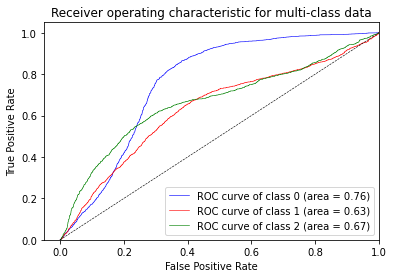

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import itertools
import matplotlib.pyplot as plt
t0 = time()
    ## test
#     predicted = model1.predict(NewXValid)
#     predicted_prob = model1.predict_proba(NewXValid)
print('Training Time:', time() - t0)
print('')
accuracy = metrics.accuracy_score(Test_y, final_pred)
auc = metrics.roc_auc_score(Test_y, final_pred_Prob, 
                                multi_class="ovr")
print('\033[1m' + 'Validation Set')
print('\033[0m')
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print('Macros:')
print("F1 Score:", f1_score(Test_y, final_pred, average='macro'))
print("Precision:", precision_score(Test_y, final_pred, average='macro'))
print("Recall:", recall_score(Test_y, final_pred, average='macro'))
print('Micros:')
print("F1 Score:", f1_score(Test_y, final_pred, average='micro'))
print("Precision:", precision_score(Test_y, final_pred, average='micro'))
print("Recall:", recall_score(Test_y, final_pred, average='micro'))


print("Detail Report:")
print(metrics.classification_report(Test_y, final_pred))

#     predicted = model1.predict(NewXtest)
#     predicted_prob = model1.predict_proba(NewXtest)
#     accuracy = metrics.accuracy_score(y_test, predicted)
#     auc = metrics.roc_auc_score(y_test, predicted_prob, 
#                                 multi_class="ovr")
#     print('\033[1m' + 'Test Set')
#     print('\033[0m')
#     print("Accuracy:",  round(accuracy,2))
#     print("Auc:", round(auc,2))
#     print('Macros:')
#     print("F1 Score:", f1_score(y_test, predicted, average='macro'))
#     print("Precision:", precision_score(y_test, predicted, average='macro'))
#     print("Recall:", recall_score(y_test, predicted, average='macro'))
#     print('Micros:')
#     print("F1 Score:", f1_score(y_test, predicted, average='micro'))
#     print("Precision:", precision_score(y_test, predicted, average='micro'))
#     print("Recall:", recall_score(y_test, predicted, average='micro'))

#     print("Detail Report:")
#     print(metrics.classification_report(y_test, predicted))
    
y_test1 = label_binarize(Test_y, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test1[:, i], final_pred_Prob[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
colors = itertools.cycle(['blue', 'red', 'green'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=0.6,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=0.6)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

0.698677296611705
0.5698496104366733
0.50652484049966